In [13]:
import sys
sys.path.insert(0, "..")
from args import *


import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morph

to_pill = transforms.ToPILImage()

In [14]:
base_model = models.resnet50(pretrained=True)
base_layers = list(base_model.children())
base_layers[:3]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True)]

In [15]:
tensor = torch.rand([1, 3, 256, 256])

In [16]:
layer0 = nn.Sequential(*base_layers[4:5]) # size=(N, 64, x.H/2, x.W/2)

In [17]:
base_layers[6][0]

Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [19]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = nn.Sequential(*base_layers[:3])
        self.down2 = nn.Sequential(*base_layers[3:5])
        self.down3 = nn.Sequential(*base_layers[5])
        self.down4 = nn.Sequential(*base_layers[6])
       
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up2 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 64, 3, 1)
        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2_1x1 = convrelu(256, 256, 1, 0)
        self.layer3_1x1 = convrelu(512, 512, 1, 0)
        self.layer4_1x1 = convrelu(1024, 1024, 1, 0)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        down1_feat = self.down1(x)
        down2_feat = self.down2(down1_feat) #1, 256, 64, 64
        down3_feat = self.down3(down2_feat) #1, 512, 32, 32
        down4_feat = self.down4(down3_feat) #1, 1024, 16, 16
        
        out = self.layer4_1x1(down4_feat)
        out = self.upsample(out)
  
        
        out = torch.cat([out, down3_feat], dim=1)
        out = self.conv_up3(out)
        out = self.layer3_1x1(out)
        
        out = self.upsample(out)
        out = torch.cat([out, down2_feat], dim=1)
        out = self.conv_up2(out)
        out = self.layer2_1x1(out)

        out = self.upsample(out)
        out = torch.cat([out, down1_feat], dim=1)
        out = self.conv_up1(out)
        out = self.layer1_1x1(out)
        
        out = self.upsample(out)
        out = self.conv_last(out)
        out = self.sigmoid(out)
#         out = F.softmax(out, dim=1)
        return out

In [20]:
# model = UNet()
# x = torch.rand([1, 3 ,256, 256])
# model(x)

In [21]:
from dataloader import *

In [22]:
model = UNet()
model = model.to(device)

In [23]:
def bce_loss(pred_masks, labels):
    loss = nn.CrossEntropyLoss()
    return loss(pred_masks, labels)


def l2_loss(x, y, d):
    out = (d*(x - y)**2).sum()
    return out


In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
critetion = torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='sum', pos_weight=None)
iter = 0
for epoch in range(2):
    print('*'*10, 'epoch: ', epoch, '*'*10)
    for i, data in enumerate(train_loader):
        image, labels, depths = data
        image, labels, depths = image.to(device), labels.to(device), depths.to(device)
        pred_masks = model(image)
#         loss = bce_loss(pred_masks[:, 0].unsqueeze(1), labels[:, 0].unsqueeze(1))
        loss = critetion(pred_masks, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
#         if iter % 10 == 0:
        print('iter: ', iter, 'loss: ', loss.mean().item())
        iter += 1

********** epoch:  0 **********
iter:  0 loss:  900869.5625
iter:  1 loss:  726817.5
iter:  2 loss:  726817.5
iter:  3 loss:  726817.5
iter:  4 loss:  726817.5


Traceback (most recent call last):


KeyboardInterrupt: 

  File "/headless/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/headless/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/headless/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/headless/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [25]:
dddda = TrainData()

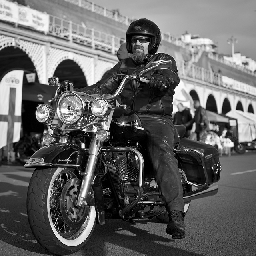

In [26]:
data = dddda[7775]
x, y, z = data
to_pill(x)

In [27]:
x = x.to(device).unsqueeze(0)

In [28]:
sig = nn.Sigmoid()

In [29]:
out = model(x)
out[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [30]:
person = out[0][0].cpu()

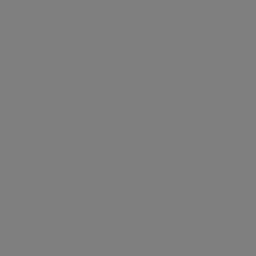

In [31]:
to_pill((sig(person)))

In [32]:
sig(person)[100]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 